In [121]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import from scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from imblearn.over_sampling import SMOTE
import xgboost

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [122]:
df = pd.read_csv("winequality-white.csv", sep = ";")
print(df.isnull().head()) # check for missing values

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          False             False        False           False      False   
1          False             False        False           False      False   
2          False             False        False           False      False   
3          False             False        False           False      False   
4          False             False        False           False      False   

   free sulfur dioxide  total sulfur dioxide  density     pH  sulphates  \
0                False                 False    False  False      False   
1                False                 False    False  False      False   
2                False                 False    False  False      False   
3                False                 False    False  False      False   
4                False                 False    False  False      False   

   alcohol  quality  
0    False    False  
1    False    False  
2    False    

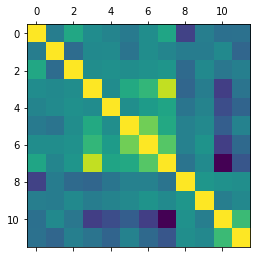

In [123]:
# correlation matrix
plt.matshow(df.corr())
plt.show()

In [124]:
# dropping residual.sugar, density, and total.sulfur.dioxide
df.drop(["residual sugar", "density", "total sulfur dioxide"], axis = 1, inplace = True)

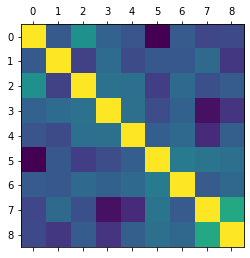

In [125]:
# new correlation matrix
plt.matshow(df.corr())
plt.show()

In [126]:
from sklearn import preprocessing
X = df.loc[:, 'fixed acidity':'alcohol']
X_std = preprocessing.scale(X)

In [127]:
# converting from numeric to categorical
def score_to_label(x):
    if x > 5:
        return 1
    else:
        return 0

In [135]:
df['label'] = df['quality'].apply(score_to_label) # converting quality to label
df.drop(['quality'], axis = 1, inplace = True)

df.head()

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,pH,sulphates,alcohol,label
0,7.0,0.27,0.36,0.045,45.0,3.00,0.45,8.8,1
1,6.3,0.30,0.34,0.049,14.0,3.30,0.49,9.5,1
2,8.1,0.28,0.40,0.050,30.0,3.26,0.44,10.1,1
3,7.2,0.23,0.32,0.058,47.0,3.19,0.40,9.9,1
4,7.2,0.23,0.32,0.058,47.0,3.19,0.40,9.9,1


In [136]:
# creating a matrix for records
# numpy is loaded
# pandas is loaded
records = np.zeros(shape=(6,3))
column_names = ['Accuracy.Rate', 'Error.Rate', 'AUC']
records = pd.DataFrame(records, columns = column_names)

In [142]:
# split the data intro training and test sets, test size is 30% of the data
from sklearn.model_selection import train_test_split
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [143]:
from sklearn.tree import DecisionTreeClassifier

# model fitting
# decision tree classifier object
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100)
# training the model 
clf_gini.fit(X_train, y_train)

# predicting
y_pred = clf_gini.predict(X_test)

In [144]:
print(accuracy_score(y_test, y_pred))

0.773469387755102


In [161]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[306 154]
 [179 831]]
              precision    recall  f1-score   support

           0       0.63      0.67      0.65       460
           1       0.84      0.82      0.83      1010

    accuracy                           0.77      1470
   macro avg       0.74      0.74      0.74      1470
weighted avg       0.78      0.77      0.78      1470



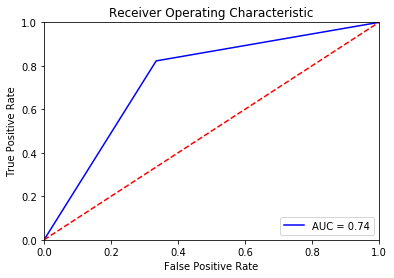

In [151]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf_gini.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic (before Pruning)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [160]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

standardizer = StandardScaler()
logit = LogisticRegression()
pipeline = make_pipeline(standardizer, logit)

# k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True, random_state = 100)

cv_results = cross_val_score(pipeline, X, y, cv = kf, scoring = "accuracy", n_jobs = -1)